### model_test.ipynb
#### tests stock prediction model generated from stock_prediction.py

In [104]:
# import modules
import yfinance as yf           # must pip install yfinance at cmd prompt
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

In [105]:
### get the data
df = yf.download('SPY') # loads all data to 'data' 
df[:5]

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,25.334036,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,25.514210,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,25.568283,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,25.838539,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,25.946659,531500


In [106]:
raw_data = np.array(df)
raw_data.shape

(7520, 6)

In [107]:
# data loaded to SPY.txt for further use
outfile = open('SPY.txt', 'w')
for row in range(raw_data.shape[0]):
    for col in range(raw_data.shape[1]):
        outfile.write(str(raw_data[row,col])+' ')
    outfile.write('\n')
outfile.close()

In [108]:
raw_data = np.loadtxt('SPY.txt')
raw_data.shape

(7520, 6)

In [109]:
# this scales all price data to Adjusted Closing Price data (& removes ACP col)
scaled_data = raw_data.copy()
scale_factor = scaled_data[:,4] / scaled_data[:,3]
print(scale_factor.shape)
for i in range(3):
    scaled_data[:,i] = scaled_data[:,i] * scale_factor
scaled_data = np.delete(scaled_data,[3],axis=1)
print(scaled_data.shape)

(7520,)
(7520, 5)


In [110]:
test_samples = 500           # save for test data 
train_samples = 3000         # train and validation data
samples = test_samples + train_samples  # total samples from data set to be used
features = 5                 # data columns representing features
non_features = 0             # data columns to keep data organized
data_step_width = features + non_features  # total # columns in data set
val_split = 0.2
split_point = int(train_samples * (1-val_split))
steps = 32                   # time steps to evaluate
maxConv = 8                  # longest convolution length to evaluate
sample_length = steps + maxConv - 1  # number of time steps needed for each sample     
first_step_idx = -samples - steps - maxConv + 1  # index of 1st datapoint
last_step_idx = -samples   # index representing sample length
print(first_step_idx, last_step_idx)

-3539 -3500


In [111]:
Y_price = scaled_data[-samples:,3]

In [112]:
def normalize(x):              #includes mean & std for pct change
    y_mean = np.mean(x[:,3])
    y_std = np.std(x[:,3])
    x_norm = preprocessing.StandardScaler().fit_transform(x)
    y_value = np.array([x_norm[-1,3], y_mean, y_std])    # returns ACP_norm, y_mean, & y_std to reconstruct ACP
    return x_norm, y_value

In [113]:
# prepare X and Y data samples
X = np.zeros(shape=(samples+1,sample_length,data_step_width))
Y = np.zeros(shape=(samples+1,3))
for i in range(samples+1):
    idxFirst = i + first_step_idx
    idxLast = i + last_step_idx
    X[i,:],Y[i,:] = normalize(scaled_data[idxFirst:idxLast or None])
Y = Y[1:]
X = X[:-1]
print(X.shape, Y.shape)

(3500, 39, 5) (3500, 3)


In [114]:
# divide data into train & test samples
X_train = X[:train_samples]
X_test = X[-test_samples:]
X1_test = X_test[:,-steps:]
X2_test = X_test
print(X.shape, X_train.shape, X_test.shape)

Y_train = Y[:train_samples]
Y_test = Y[-test_samples:]
print(Y.shape, Y_train.shape, Y_test.shape)

(3500, 39, 5) (3000, 39, 5) (500, 39, 5)
(3500, 3) (3000, 3) (500, 3)


In [116]:
#### shows Y value offset by X(ACP) value by 1 timestep
for i in range(-5,0,1):
    print(X[i,-1,3], '|', Y[i,0])

1.800485531484998 | 1.6627283247794908
1.6627283247794908 | 1.5425665874437036
1.5425665874437036 | 1.0048170596372883
1.0048170596372883 | 0.5708909473546261
0.5708909473546261 | 0.48315082601458753


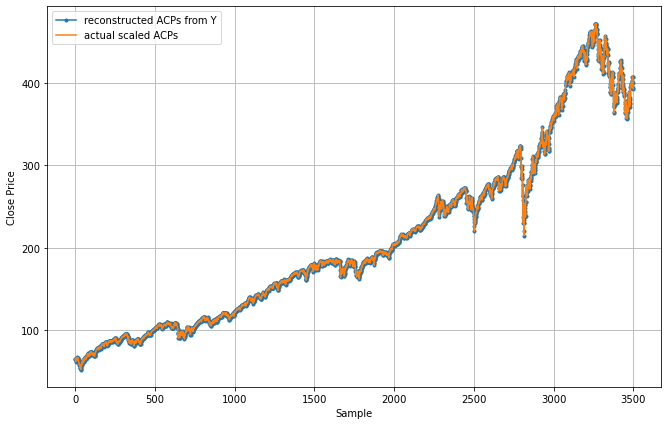

In [117]:
#### compares reconstructed ACP's with actual ACP's
temp = np.add(np.multiply(Y[:,0], Y[:,2]), Y[:,1])

plt.plot(temp, label='reconstructed ACPs from Y', marker='.')
plt.plot(scaled_data[-samples:,3], label='actual scaled ACPs')
plt.xlabel('Sample')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

In [118]:
# create separate inputs for 2 convolution layers
X2_train = X_train
X1_train = X_train[:,-steps:]

In [119]:
# load trained model
model = keras.models.load_model("stock_prediction.h5")

In [124]:
Y_predict = model.predict([X1_test,X2_test])
print(Y_predict[-5:])
print(Y_test[-5:,-3])
print(Y_predict.shape, Y_test.shape)

[[0.650493 ]
 [1.1207392]
 [1.3950074]
 [2.119225 ]
 [1.2769105]]
[1.66272832 1.54256659 1.00481706 0.57089095 0.48315083]
(500, 1) (500, 3)


In [125]:
Y_predict_price = (Y_predict[:,0] * Y_test[:,-1]) + Y_test[:,-2]
Y_actual_price = (Y_test[:,0] * Y_test[:,-1]) + Y_test[:,-2]
print(Y_predict_price.shape, Y_actual_price.shape)
print(Y_actual_price[-5:])
print(Y_price[-5:])
print(Y_predict_price[-5:])

(500,) (500,)
[407.38000488 406.91000366 399.58999634 393.82998657 393.16000366]
[407.38000488 406.91000366 399.58999634 393.82998657 393.16000366]
[392.40807947 400.62263957 405.28176655 415.45123852 403.61463451]


In [126]:
error = np.zeros(shape=Y_predict.shape)
print(error.shape)
for i in range(Y_predict.shape[0]):    
    error[i] = abs(Y_predict_price[i]-Y_actual_price[i])/Y_actual_price[i]
MAE = np.mean(error)
std = np.std(error)
# print(error[:10])
print('MAE:', MAE)
print('Std Dev:', std)

(500, 1)
MAE: 0.019533509372026043
Std Dev: 0.020902438090676385


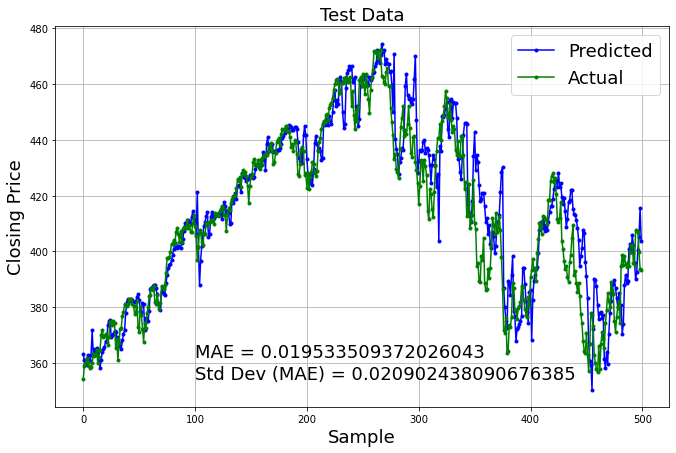

In [127]:
plt.plot(Y_predict_price[:], label='Predicted', color='blue', marker='.')
plt.plot(Y_price[-500:], label='Actual', color='green', marker='.')
plt.xlabel('Sample', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend(fontsize=18)
plt.title('Test Data', fontsize=18)
plt.grid()
plt.text(100,362,'MAE = '+ str(MAE), fontsize=18)
plt.text(100,354,'Std Dev (MAE) = '+str(std), fontsize=18)
plt.rcParams['figure.figsize'] = (11,7)
plt.show()

In [128]:
start_point = 0
wins = 0
losses = 0
for i in range(249):
    Y_predict_change = Y_predict[start_point+i+1]-Y_predict[start_point+i]
    Y_actual_change = Y_test[start_point+i+1,0]-Y_test[start_point+i,0]
    if np.sign(Y_predict_change) == np.sign(Y_actual_change):
        wins += 1
    else:
        losses += 1
print('winning trades:', wins, ' losing trades:', losses) 

winning trades: 114  losing trades: 135


In [129]:
Y_train_predict = model.predict([X1_train,X2_train])
print(Y_train_predict[-5:])
Y_train_predict.shape

[[0.42291263]
 [0.65771663]
 [1.2298881 ]
 [1.3374465 ]
 [1.6036406 ]]


(3000, 1)

In [130]:
Y_train_predict_price = (Y_train_predict[:,0] * Y_train[:,-1]) + Y_train[:,-2]
Y_train_actual_price = (Y_train[:,0] * Y_train[:,-1]) + Y_train[:,-2]
print(Y_train_predict_price.shape, Y_train_actual_price.shape)
print(Y_train_actual_price[:5])
print(Y_price[:5])
print(Y_train_predict_price[:5])

(3000,) (3000,)
[64.65647888 64.67947388 65.18527222 61.74436569 64.41125488]
[64.65647888 64.67947388 65.18527222 61.74436569 64.41125488]
[65.94146291 64.59004288 61.14290608 61.66890751 63.38365572]


In [131]:
i = 1000
n = 25

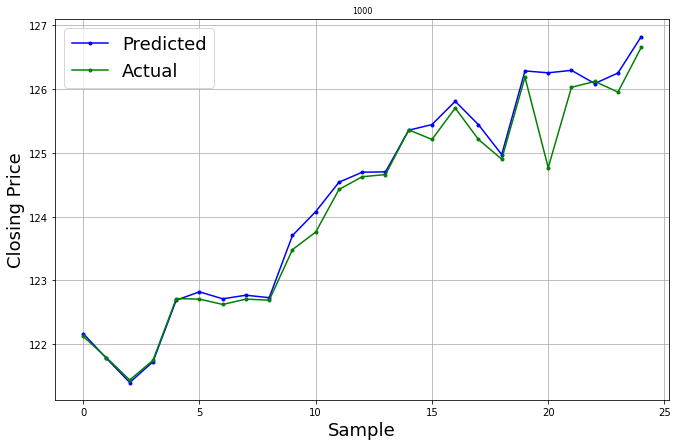

In [132]:
plt.plot(Y_train_predict_price[i:i+n], label='Predicted', color='blue', marker='.')
plt.plot(Y_price[i:i+n], label='Actual', color='green', marker='.')
plt.xlabel('Sample', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend(fontsize=18, loc='upper left')
plt.grid()
plt.title(i, fontsize=8)
plt.rcParams['figure.figsize'] = (11,7)
plt.show()
i += n